## [psmpy package introduction](https://pypi.org/project/psmpy/)

## 1. Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# sns.set()  # set the style

In [2]:
# !pip install psmpy
from psmpy import PsmPy
from psmpy.plotting import *

## 2. Import Data
### [Download data from Kaggle](https://www.kaggle.com/datasets/harrywang/propensity-score-matching/)


In [3]:
df=pd.read_csv('./data/groupon.csv')
df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500


### 2.1. \[Before Match\] student's t-test for revenue (dependent variable)

In [4]:
# separate control and treatment for t-test
df_control = df[df.treatment==0]
df_treatment = df[df.treatment==1]

In [5]:
from scipy.stats import ttest_ind

print(df_control.revenue.mean()," | ", df_treatment.revenue.mean())

# compare samples
_, p = ttest_ind(df_control.revenue, df_treatment.revenue)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

9720.987854251012  |  12750.694444444445
p=0.040
different distributions/different group mean (reject H0)


In [6]:
print(df_control.fb_likes.mean()," | ", df_treatment.fb_likes.mean())

# compare samples
_, p = ttest_ind(df_control.fb_likes, df_treatment.fb_likes)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

77.9412955465587  |  113.20370370370371
p=0.004
different distributions/different group mean (reject H0)


### 2.2. Calculate Propensity Scores

In [7]:
# choose features for propensity score calculation
X = df[['prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured', 'limited_supply']]
## hence @3. Matching Procedure, exclude=['min_req', 'start_date', 'fb_likes', 'quantity_sold', 'revenue']
y = df['treatment']

X.head()

,prom_length,price,discount_pct,coupon_duration,featured,limited_supply
0,4,99,51,185,1,1
1,2,95,41,9,0,1
2,3,25,50,38,0,1
3,3,50,50,369,0,1
4,4,25,52,185,0,1


In [8]:
# use logistic regression to calculate the propensity scores
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression()

In [9]:
# get the coefficients
coeffs=pd.DataFrame({
    'column':X.columns.to_numpy(),
    'coeff':lr.coef_.ravel()
})
coeffs

,column,coeff
0,prom_length,-0.328371
1,price,-0.008597
2,discount_pct,-0.007940
3,coupon_duration,0.003520
4,featured,0.307995
5,limited_supply,-0.366498


In [10]:
# prediction
pred_binary = lr.predict(X)  # binary 0 control, 1, treatment
pred_prob = lr.predict_proba(X)  # probabilities for classes

print('the binary prediction is:', pred_binary[0])
print('the corresponding probabilities are:', pred_prob[0])

the binary prediction is: 0
the corresponding probabilities are: [0.74080749 0.25919251]


In [11]:
# the propensity score (ps) is the probability of being 1 (i.e., in the treatment group)
df['ps'] = pred_prob[:, 1]

# calculate the logit of the propensity score for matching if needed
df['ps_logit'] = df.ps.apply(lambda p: math.log(p / (1-p))) # logit

df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue,ps,ps_logit
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460,0.259193,-1.050170
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050,0.230198,-1.207194
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500,0.288405,-0.903144
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500,0.511781,0.047131
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500,0.325212,-0.729919


### 2.3. Each Variable's affecting Overlap

<AxesSubplot:xlabel='ps', ylabel='Count'>

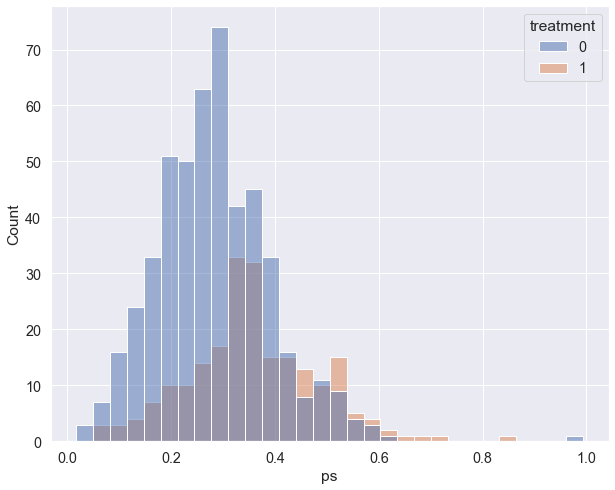

In [12]:
# check the overlap of ps for control and treatment using histogram
# if there is not much overlap, the matching won't work
sns.histplot(data=df, x='ps', hue='treatment')  # multiple="dodge" for 

<AxesSubplot:xlabel='ps1', ylabel='Count'>

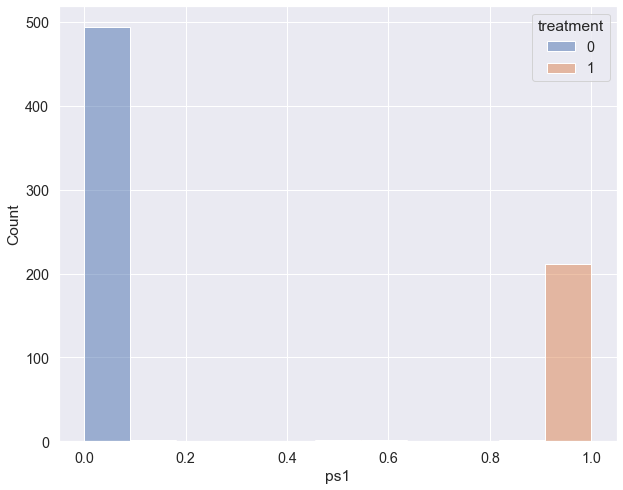

In [13]:
# adding 'min_req' here makes matching not working - because treatment is derived from min_req
# there is no overlap and thus matching will not work
X1 = df[['min_req', 'prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']]
y = df['treatment']

# use logistic regression to calculate the propensity scores
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X1, y)

pred_prob1 = lr1.predict_proba(X1)  # probabilities for classes
df['ps1'] = pred_prob1[:, 1]

sns.histplot(data=df, x='ps1', hue='treatment')

<AxesSubplot:xlabel='start_date', ylabel='revenue'>

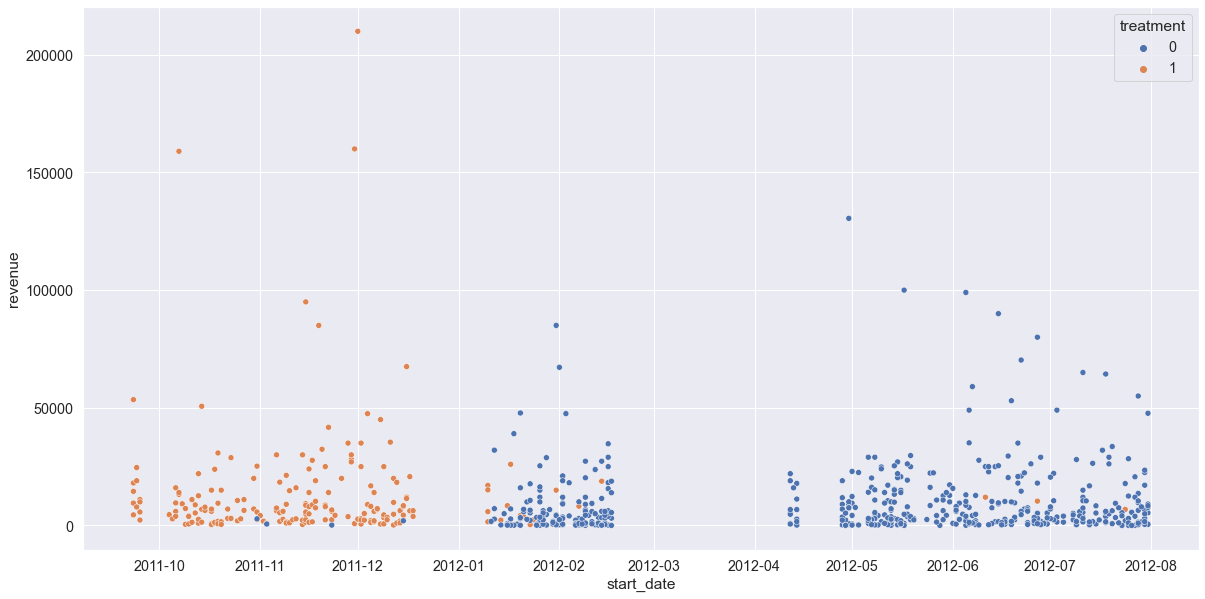

In [14]:
# stating date can also determine treatment value for most cases
# so we do not include it in the propensity score calculation
df.start_date = pd.to_datetime(df.start_date) # convert column data type to time format
fig, ax = plt.subplots(figsize=(20, 10))
sns.scatterplot(data=df, x='start_date', y='revenue', hue='treatment')

<AxesSubplot:xlabel='ps2', ylabel='Count'>

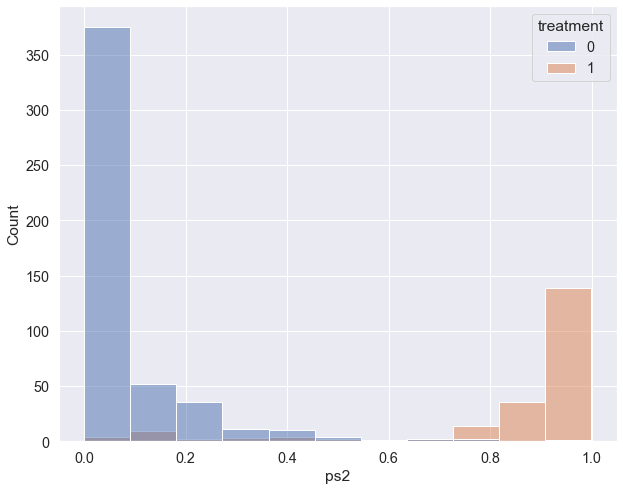

In [15]:
# adding 'starting_date' here via a `recency` feature
# there is only little overlap resulting in not enough matched observations

last_date = df.start_date.max()
df['recency'] = (last_date - df.start_date).dt.days

X2 = df[['recency', 'prom_length', 'price', 'discount_pct', 'coupon_duration', 'featured','limited_supply']]
y = df['treatment']

# use logistic regression to calculate the propensity scores
lr2 = LogisticRegression(max_iter=1000)
lr2.fit(X2, y)

pred_prob2 = lr2.predict_proba(X2)  # probabilities for classes
df['ps2'] = pred_prob2[:, 1]

sns.histplot(data=df, x='ps2', hue='treatment')

## 3. Matching Procedure

In [16]:
# again, import data
df=pd.read_csv('./data/groupon.csv')
df.head()

,deal_id,start_date,min_req,treatment,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,fb_likes,quantity_sold,revenue
0,heli-flights,9/23/2011,10,1,4,99,51,185,1,1,290,540,53460
1,gl-champion-series-tennis-electric-factory,9/23/2011,20,1,2,95,41,9,0,1,43,190,18050
2,realm-of-terror-horror-experience,9/23/2011,50,1,3,25,50,38,0,1,208,380,9500
3,newport-gourmet,9/23/2011,15,1,3,50,50,369,0,1,16,90,4500
4,the-clayroom,9/23/2011,20,1,4,25,52,185,0,1,85,580,14500


In [17]:
# exclude: ignore any covariates (columns) passed to the it during model fitting
# indx - required parameter that references a unique ID number for each case
psm=PsmPy(df, treatment='treatment', indx='deal_id',
          exclude=['min_req', 'start_date', 'fb_likes', 'quantity_sold', 'revenue'])

In [18]:
psm.logistic_ps(balance=False) # balance: whether the logistic regression will run in a balanced fashion, default=True.
psm.predicted_data

,deal_id,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,propensity_score,propensity_logit,treatment
0,3rd-coast-cruising-1,3,75,50,378,1,1,0.541488,0.166333,0
1,516-skydive-new-york,7,145,39,170,0,1,0.063623,-2.689036,0
2,92nd-st-y-nyc,3,29,82,125,0,0,0.392219,-0.437994,0
3,above-all-cruises-ny,4,39,51,207,0,1,0.317265,-0.766371,0
4,adaptive-adventures,3,10,0,5,0,1,0.321258,-0.747996,0
...,...,...,...,...,...,...,...,...,...,...
705,gl-windy-city-circus-1,4,20,50,5,0,1,0.212691,-1.308780,1
706,lets-go-paragliding,6,99,58,73,0,1,0.083981,-2.389441,1
707,spare-time-chicago-3,4,12,74,166,0,0,0.392404,-0.437220,1
708,dc-gmt-slice-chicago-tours,7,22,51,106,0,1,0.128638,-1.913052,1


In [19]:
psm.knn_matched(matcher='propensity_score', replacement=False, caliper=None)

C:\Users\2joon\anaconda3\lib\site-packages\psmpy\psmpy.py:346: UserWarning: Some values do not have a match
  warnings.warn('Some values do not have a match')


## 4. Checkout Results

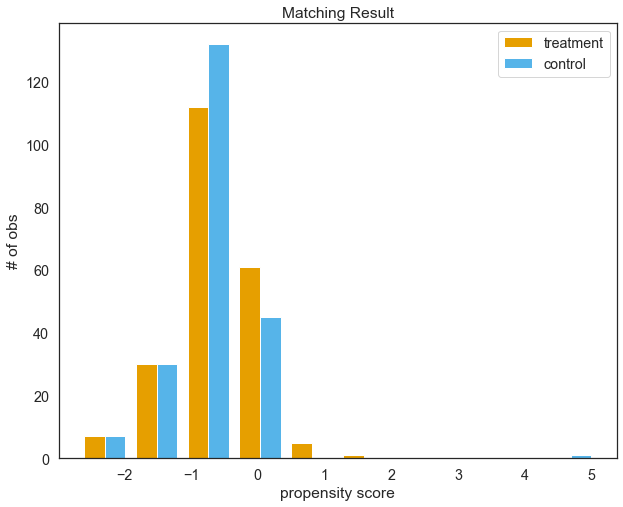

In [20]:
psm.plot_match(Title='Matching Result',
               Ylabel='# of obs',
               Xlabel='propensity score',
               names=['treatment', 'control'])

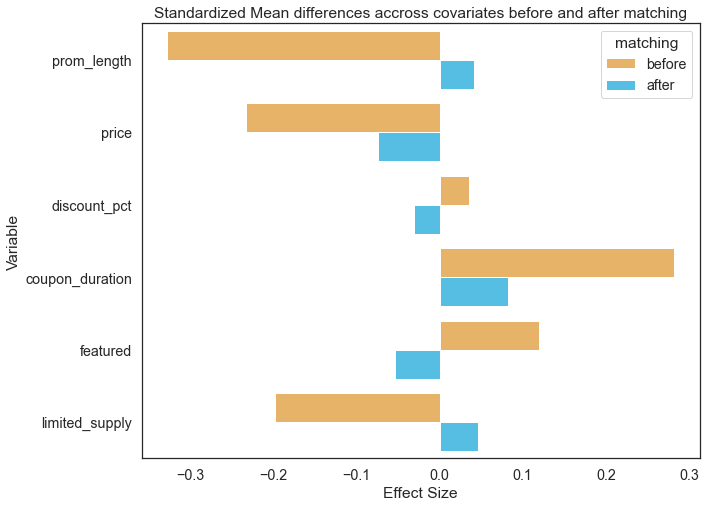

In [21]:
psm.effect_size_plot()

In [22]:
psm.effect_size.set_index(['Variable', 'matching'])

Effect Size
Variable        matching             
prom_length     before      -0.328313
                after        0.041209
price           before      -0.233573
                after       -0.074647
discount_pct    before       0.035411
                after       -0.031279
coupon_duration before       0.282300
                after        0.082127
featured        before       0.119074
                after       -0.053412
limited_supply  before      -0.198547
                after        0.046427

In [23]:
psm.matched_ids

,deal_id,matched_ID
0,heli-flights,gl-second-stage-theatre
1,gl-champion-series-tennis-electric-factory,luna-park-at-coney-island-3
2,realm-of-terror-horror-experience,gl-stripped-the-play
3,newport-gourmet,created-by-you
4,the-clayroom,sportations-nyc-1
...,...,...
211,gl-windy-city-circus-1,gl-chicago-wolves-1
212,lets-go-paragliding,canlan-ice-sports-6
213,spare-time-chicago-3,gl-at-barclays-center-sports
214,dc-gmt-slice-chicago-tours,seabreeze-charter-2


In [26]:
# psm.df_matched
df_matched=pd.merge(psm.df_matched, df[['deal_id', 'fb_likes', 'quantity_sold', 'revenue']], on='deal_id', how='left')
df_matched

,deal_id,prom_length,price,discount_pct,coupon_duration,featured,limited_supply,propensity_score,propensity_logit,treatment,fb_likes,quantity_sold,revenue
0,heli-flights,4,99,51,185,1,1,0.263701,-1.026818,1,290,540,53460
1,gl-champion-series-tennis-electric-factory,2,95,41,9,0,1,0.218561,-1.274072,1,43,190,18050
2,realm-of-terror-horror-experience,3,25,50,38,0,1,0.284296,-0.923251,1,208,380,9500
3,newport-gourmet,3,50,50,369,0,1,0.505683,0.022734,1,16,90,4500
4,the-clayroom,4,25,52,185,0,1,0.325569,-0.728293,1,85,580,14500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
426,gl-chicago-wolves-1,4,18,53,3,0,1,0.212703,-1.308711,0,44,520,9360
427,canlan-ice-sports-6,4,148,51,8,0,1,0.084488,-2.382875,0,13,10,1480
428,gl-at-barclays-center-sports,3,25,58,76,1,1,0.379116,-0.493302,0,122,900,22500
429,seabreeze-charter-2,3,180,50,126,0,1,0.127306,-1.924996,0,39,60,10800


In [27]:
# matched control and treatment
df_matched_control = df_matched[df_matched.treatment==0]
df_matched_treatment = df_matched[df_matched.treatment==1]

### 4.1. \[After Match\] student's t-test for revenue (dependent variable)

In [28]:
print(df_matched_control.revenue.mean()," | ", df_matched_treatment.revenue.mean())

# compare samples
_, p = ttest_ind(df_matched_control.revenue, df_matched_treatment.revenue)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

9659.706976744186  |  12750.694444444445
p=0.102
same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)


In [29]:
print(df_matched_control.fb_likes.mean()," | ", df_matched_treatment.fb_likes.mean())

# compare samples
_, p = ttest_ind(df_matched_control.fb_likes, df_matched_treatment.fb_likes)
print(f'p={p:.3f}')

# interpret
alpha = 0.05  # significance level
if p > alpha:
    print('same distributions/same group mean (fail to reject H0 - we do not have enough evidence to reject H0)')
else:
    print('different distributions/different group mean (reject H0)')

70.08837209302325  |  113.20370370370371
p=0.003
different distributions/different group mean (reject H0)
